# Tensorflow ile DeepDream 

Bu notebook, Google'ın önceden eğitilmiş Inception sinir ağını kullanarak Kaggle dan indirilen Sample Images veri setindeki seçilen fotoğraflardan DeepDream görüntüleri üretir.
DeepDream keras sayfası için: https://keras.io/examples/generative/deep_dream/

### Ön Eğitimli Modelin ve Veri Setinin Yüklenmesi

In [11]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

--2022-05-15 19:36:58--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  37.8MB/s    in 1.3s    

2022-05-15 19:37:00 (37.8 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


In [2]:
!pip install kaggle
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets download -d carloalbertobarbano/sampleimages -p "/content"

 90% 73.0M/81.1M [00:02<00:00, 32.3MB/s]
100% 81.1M/81.1M [00:03<00:00, 28.2MB/s]


In [4]:
import zipfile
zf = "/content/sampleimages.zip"
target_dir = "/content"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
with open("/content/data/car2.jpg", 'rb') as f:
  file_contents = f.read()

In [6]:
from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

In [12]:
# TensorFlow session olusturma ve modeli yukleme
graph = tf.Graph()
sess = tf.compat.v1.InteractiveSession(graph=graph)
with tf.compat.v1.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.compat.v1.placeholder(np.float32, name='input') # input tensorunu tanimlama
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Katman cikti tensorunu almak icin'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Baslangic ​​resmini yukle

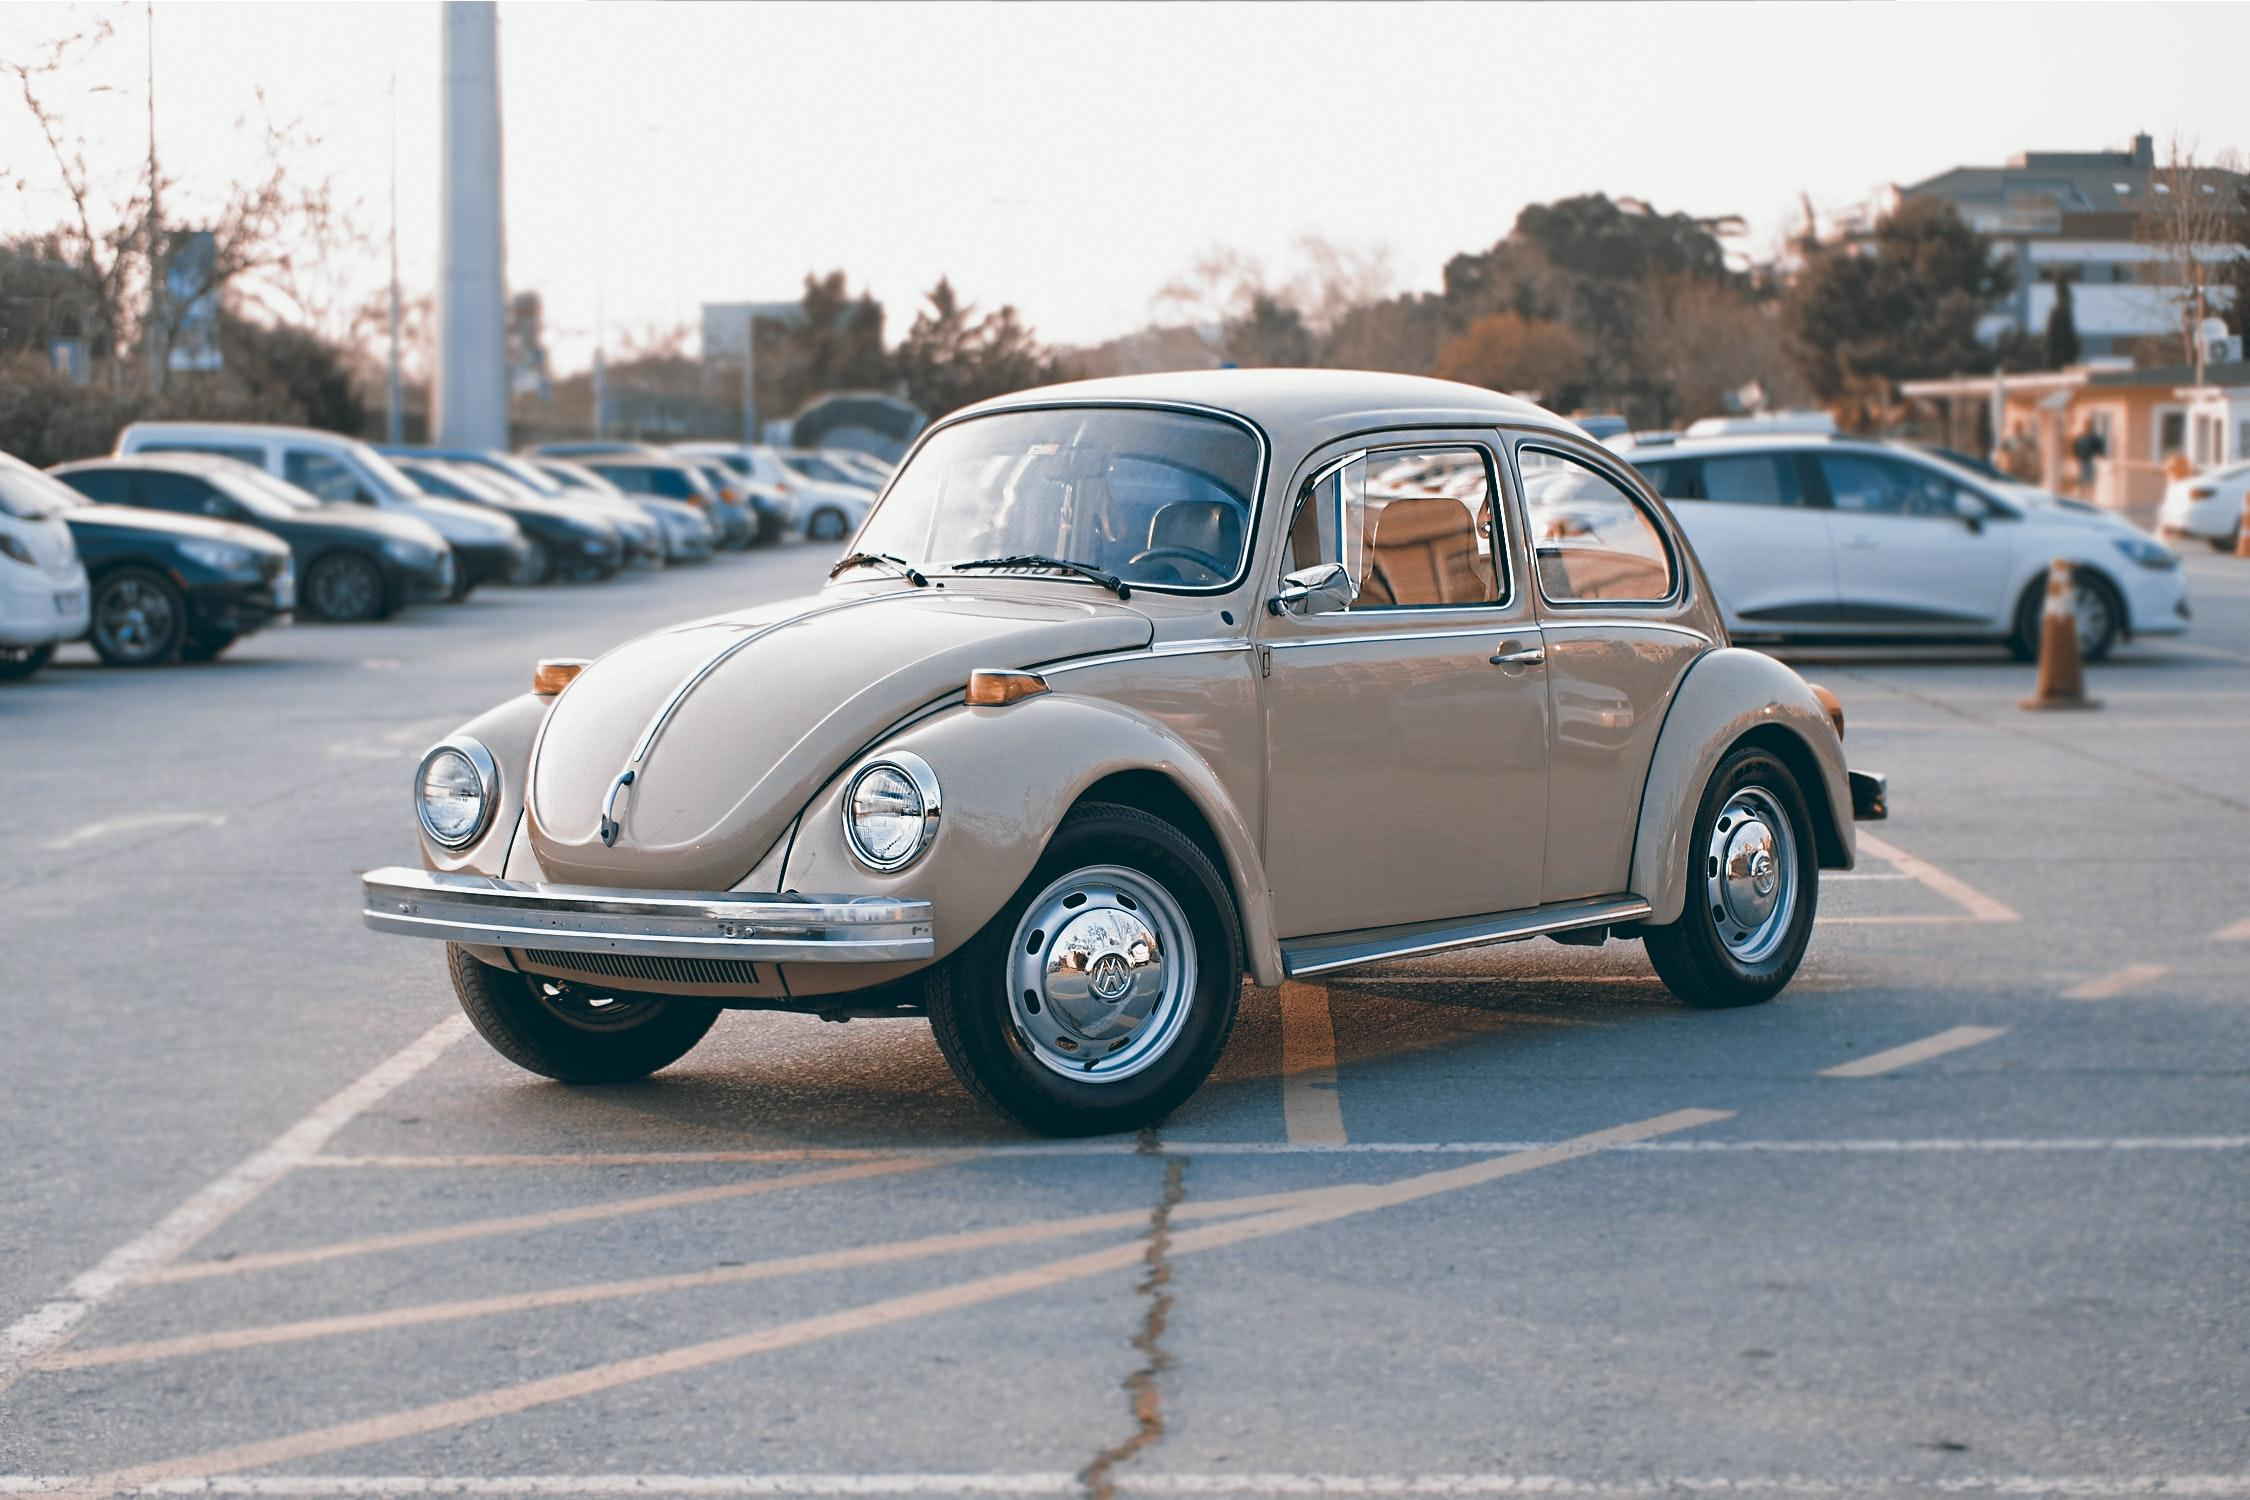

In [13]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

### Ana Deepdream Kodu

In [14]:
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

In [15]:
def resize(img, new_size):
    return sess.run(tf.compat.v1.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

In [16]:
# Gradyan uygulama
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Birden cok iterasyonda sinirlari bulaniklastirmak icin 
    goruntuye rastgele kaydırmalar uygulanir. '''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Goruntu gradyanini goruntuye ekleyip ve sonucu dondurme
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

In [17]:
# Deepdream uygulamasi
def render_deepdream(t_obj, input_img, show_steps = True):
    # Optimizasyon hedefini tek bir sayiya daraltma (loss)
    t_score = tf.reduce_mean(t_obj)
    # Gradyani aldik
    t_grad = tf.gradients(t_score, t_input)[0]

    # goruntuyu bir dizi oktava bölme (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # oktav olusturma
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

### Deepdream Uygulamasi

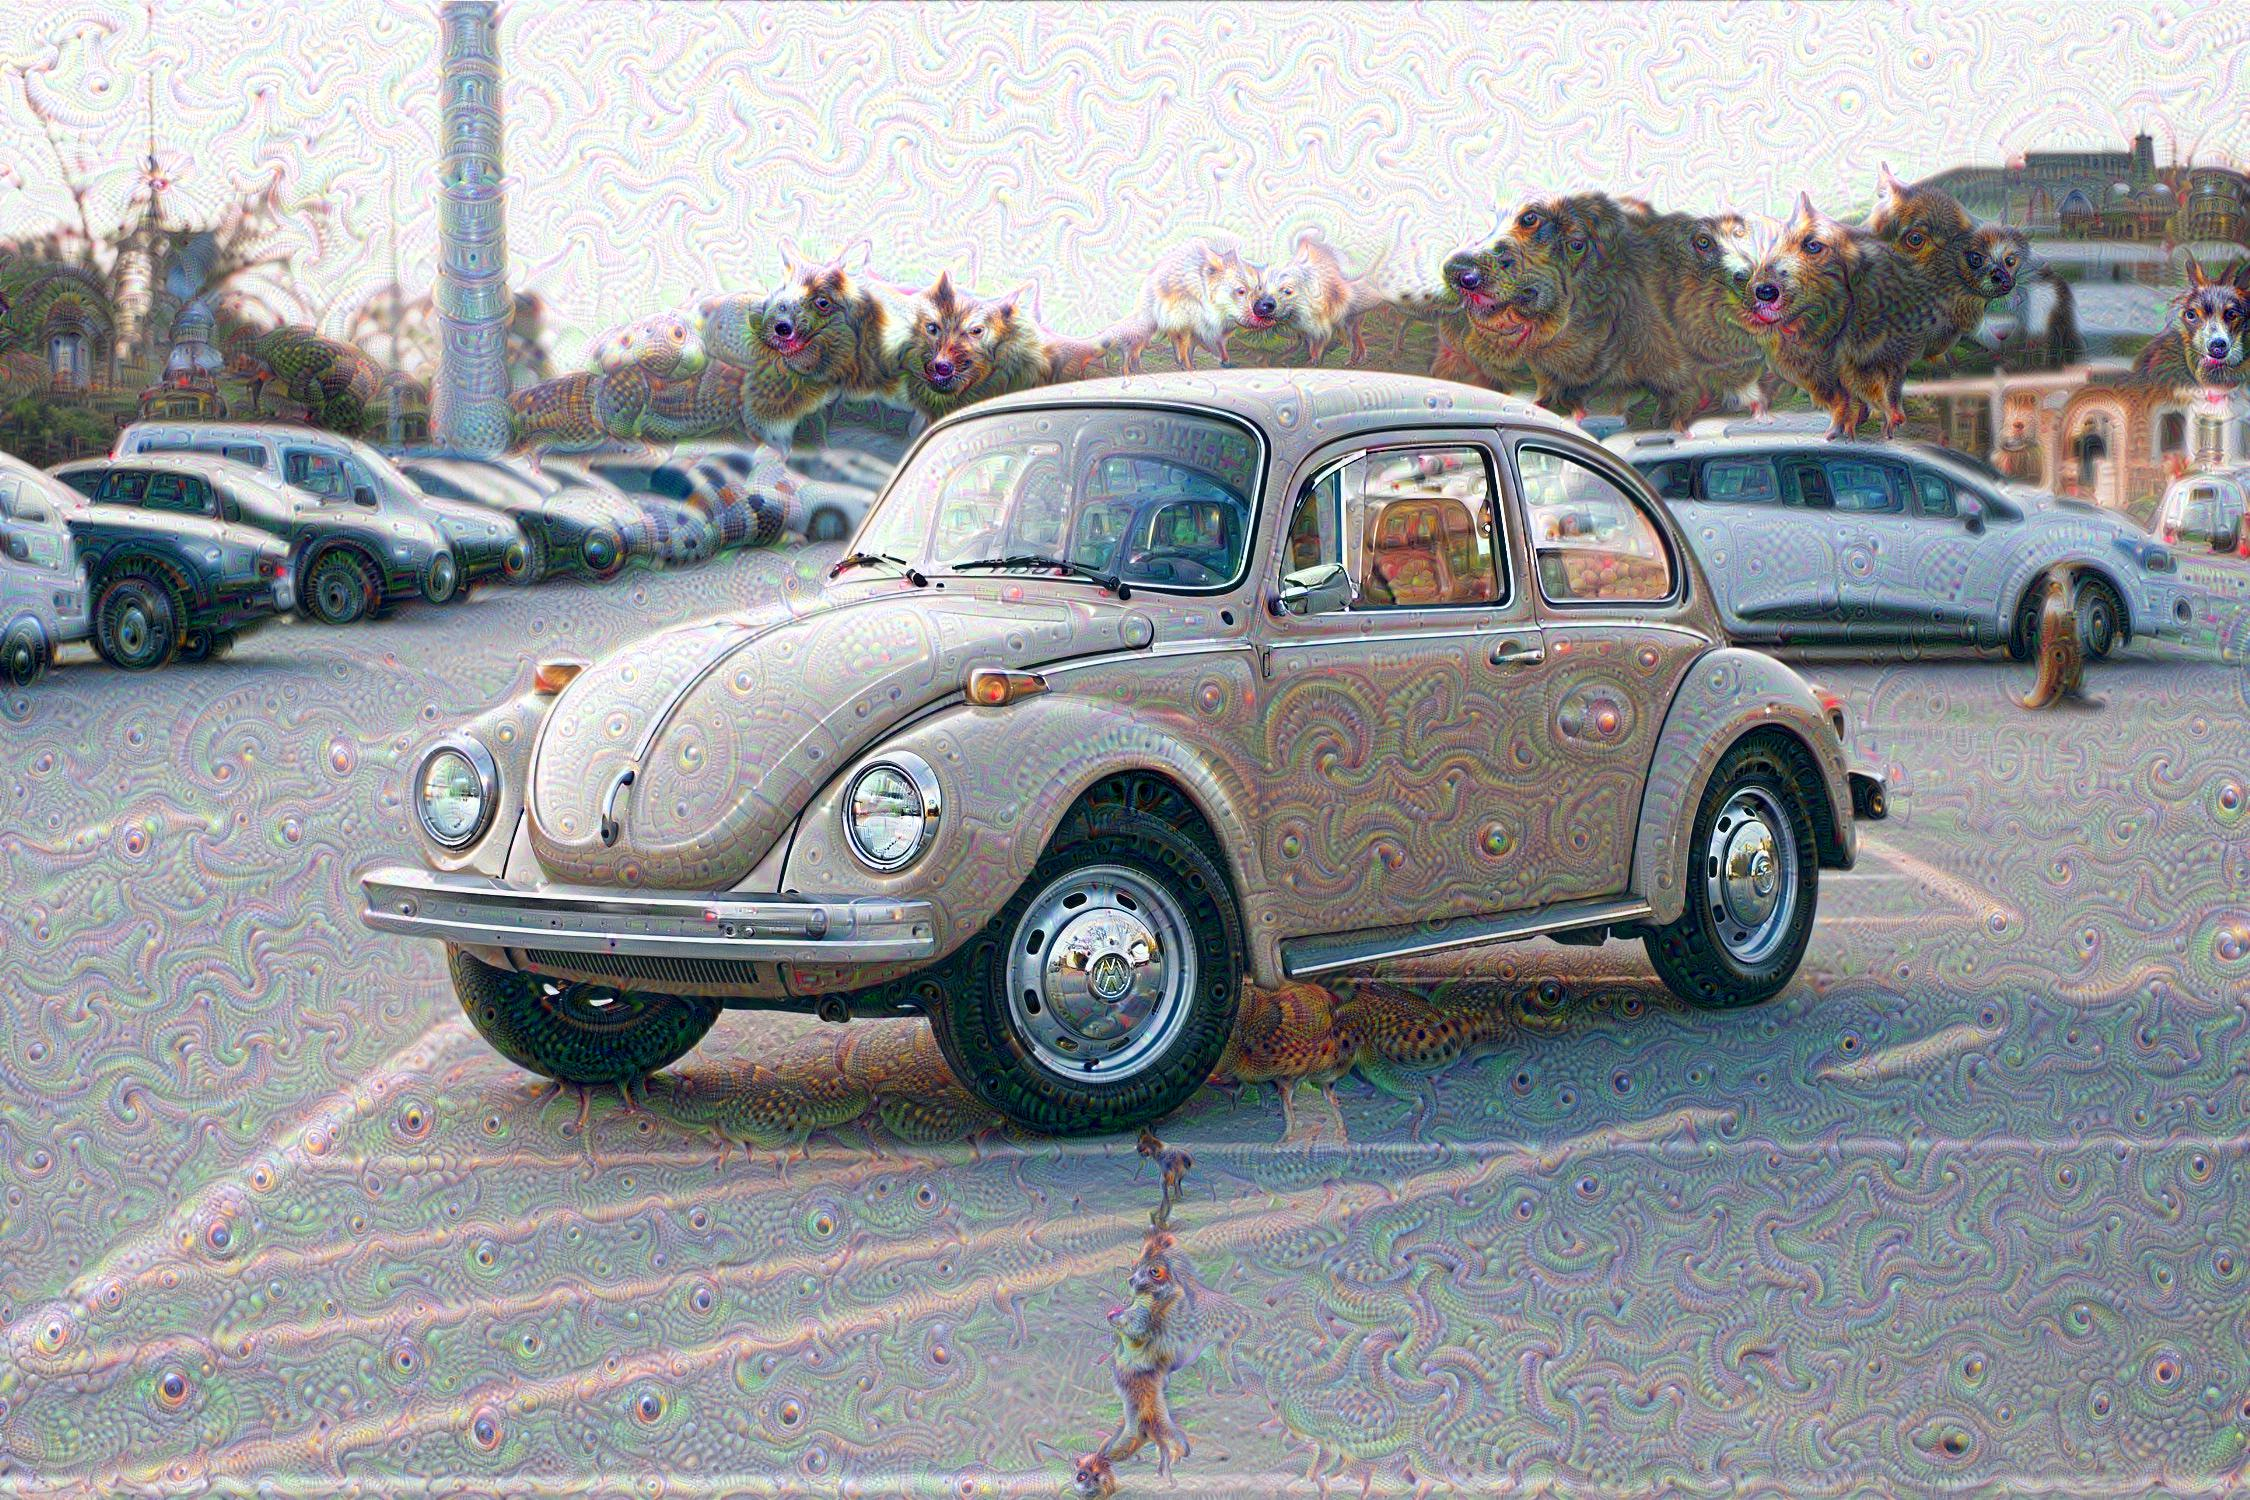

In [18]:
# slider i kullanabilirsiniz
octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 10 #@param {type:"slider", max: 50}
strength = 200 #@param {type:"slider", max: 1000}
layer = "mixed4c"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)

### Tek Nöron İçin

Ayrıca, tüm bir katmana karşı değil, yalnızca bir nöronun etkinliğine karşı deneyebilir ve optimize edebiliriz

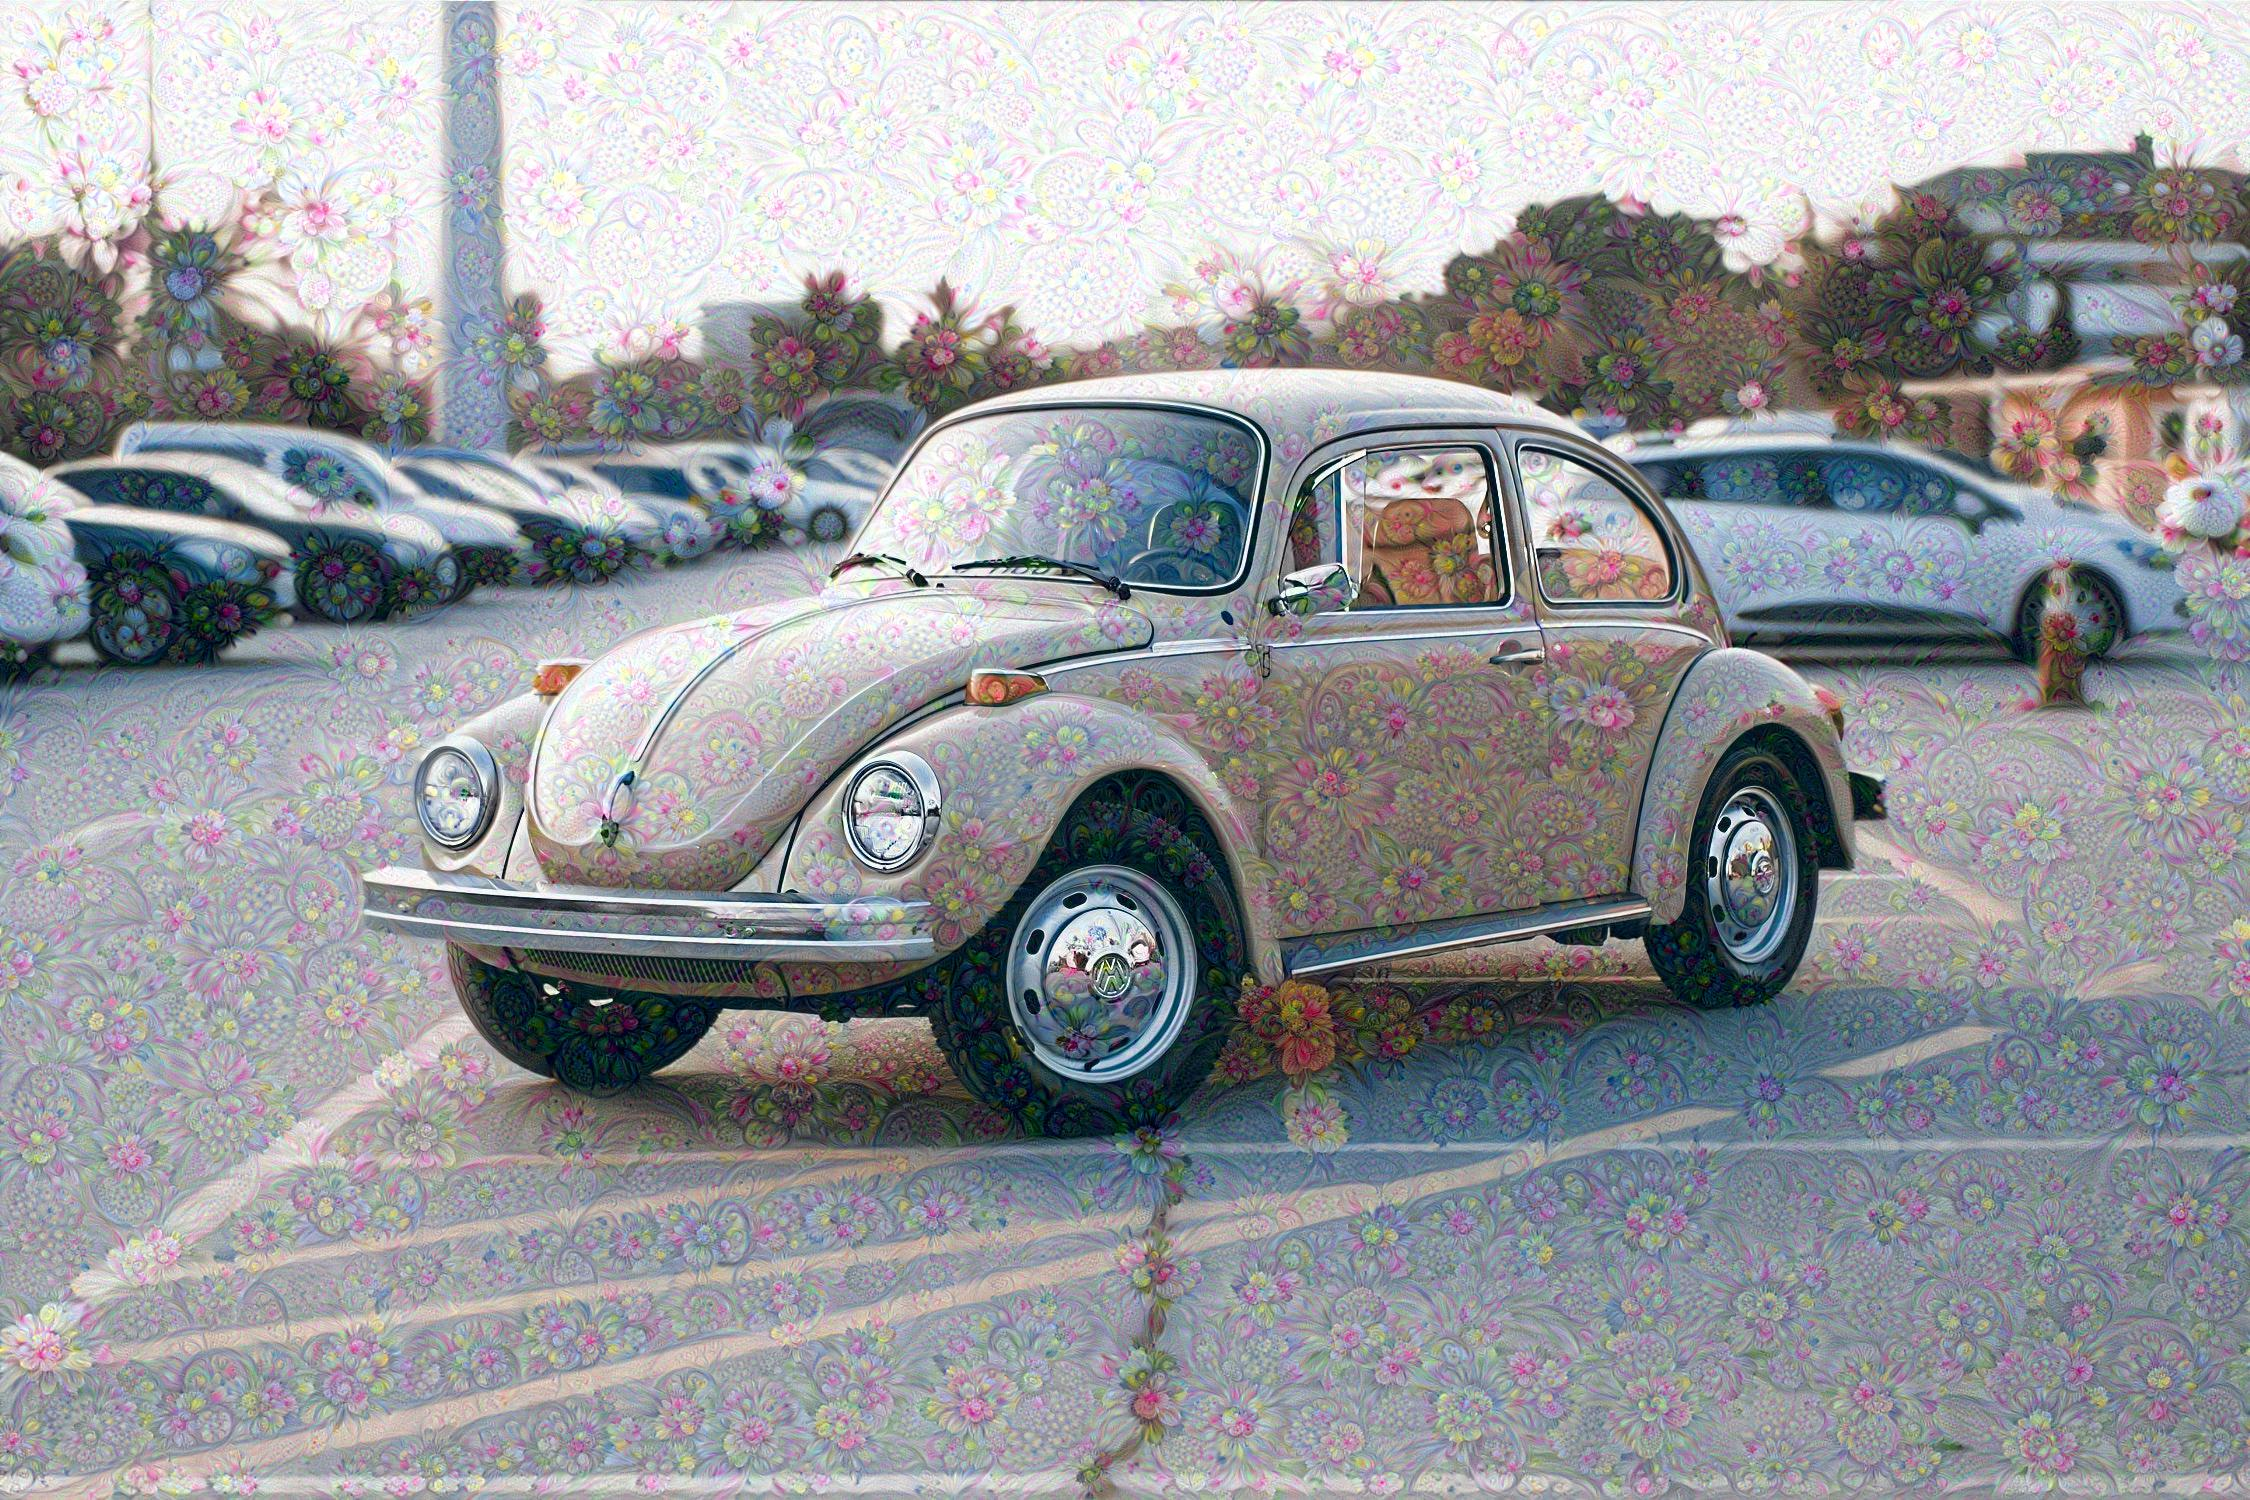

In [19]:
feature_channel = 139 #@param {type:"slider", max: 512}
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
if feature_channel >= T(layer).shape[3]:
  print("Feature channel exceeds size of layer ", layer, " feature space. ")
  print("Choose a smaller channel number.")
else:
  render_deepdream(T(layer)[:,:,:,feature_channel], img0)

### Yakınlaştırma yinelemeli(iterative) DeepDream

Resme tekrar tekrar yaklaşabiliriz

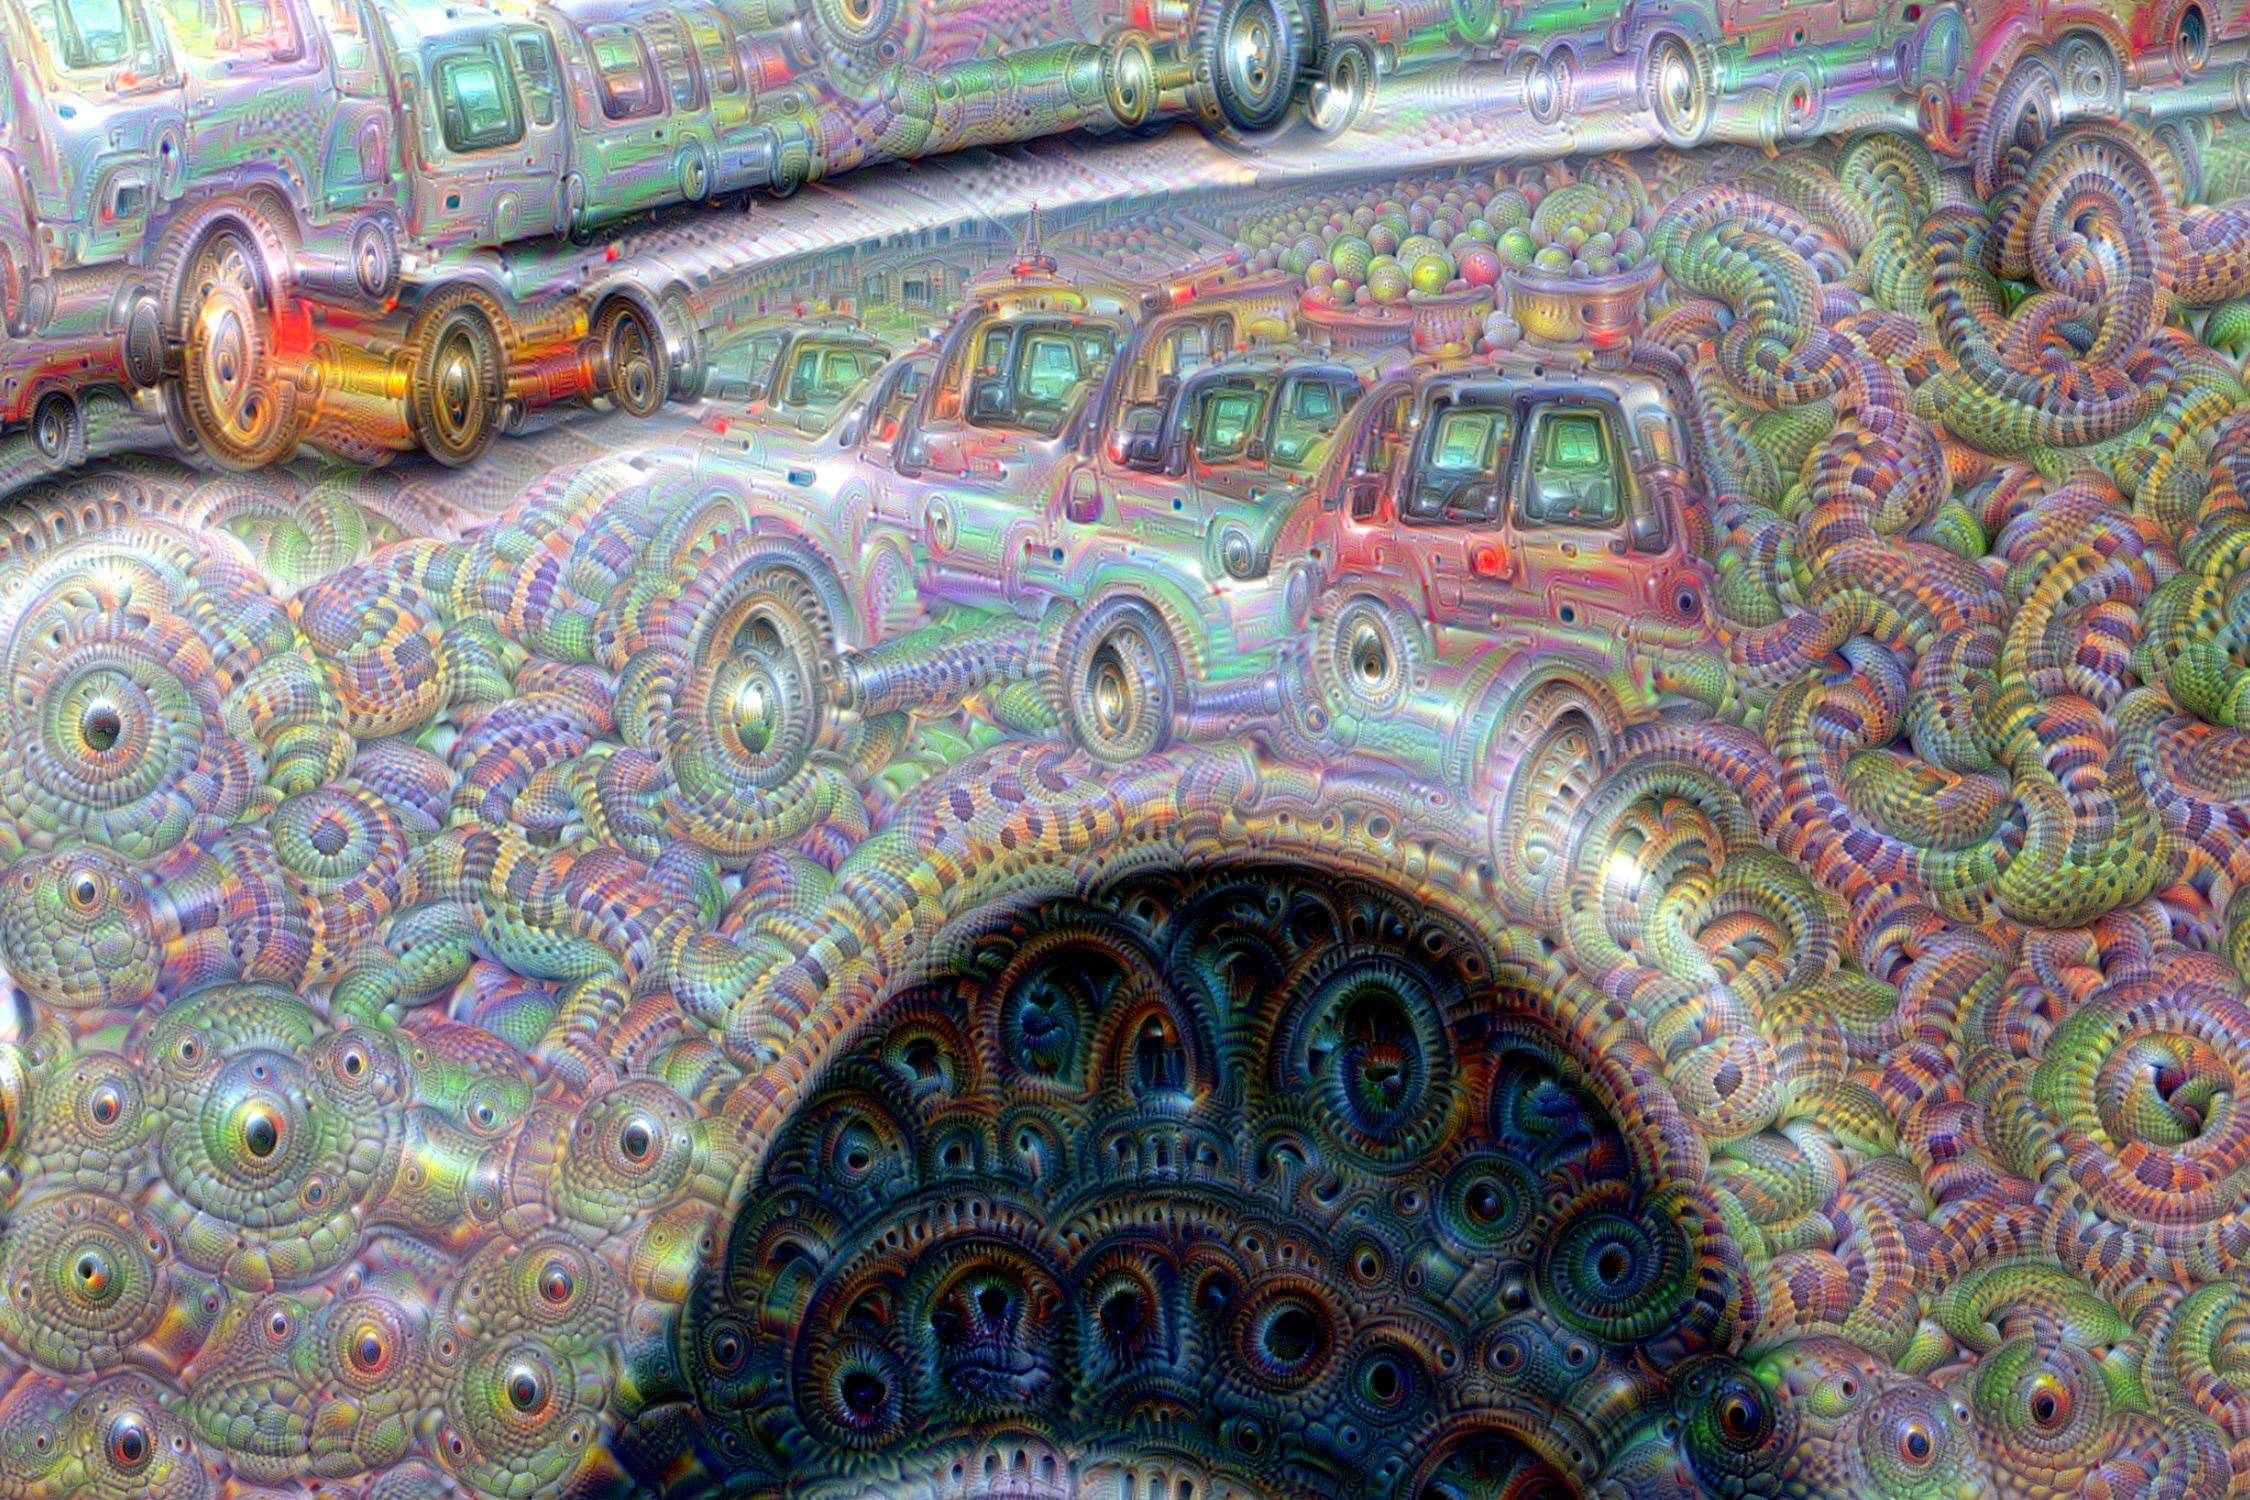

In [20]:
layer = "mixed4d_3x3_bottleneck_pre_relu"  #@param ["mixed4d_3x3_bottleneck_pre_relu", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]
iter_n = 5 #@param {type:"slider", max: 50}
strength = 150 #@param {type:"slider", max: 1000}
zooming_steps = 20 #@param {type:"slider", max: 512}
zoom_factor = 1.1 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape
for i in range(zooming_steps):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  clear_output()
  showarray(frame)
  newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
  frame = resize(frame, newsize)
  frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]

### Inception Modeli İle Oluşturduğumuz Modeli Genişletme

In [21]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

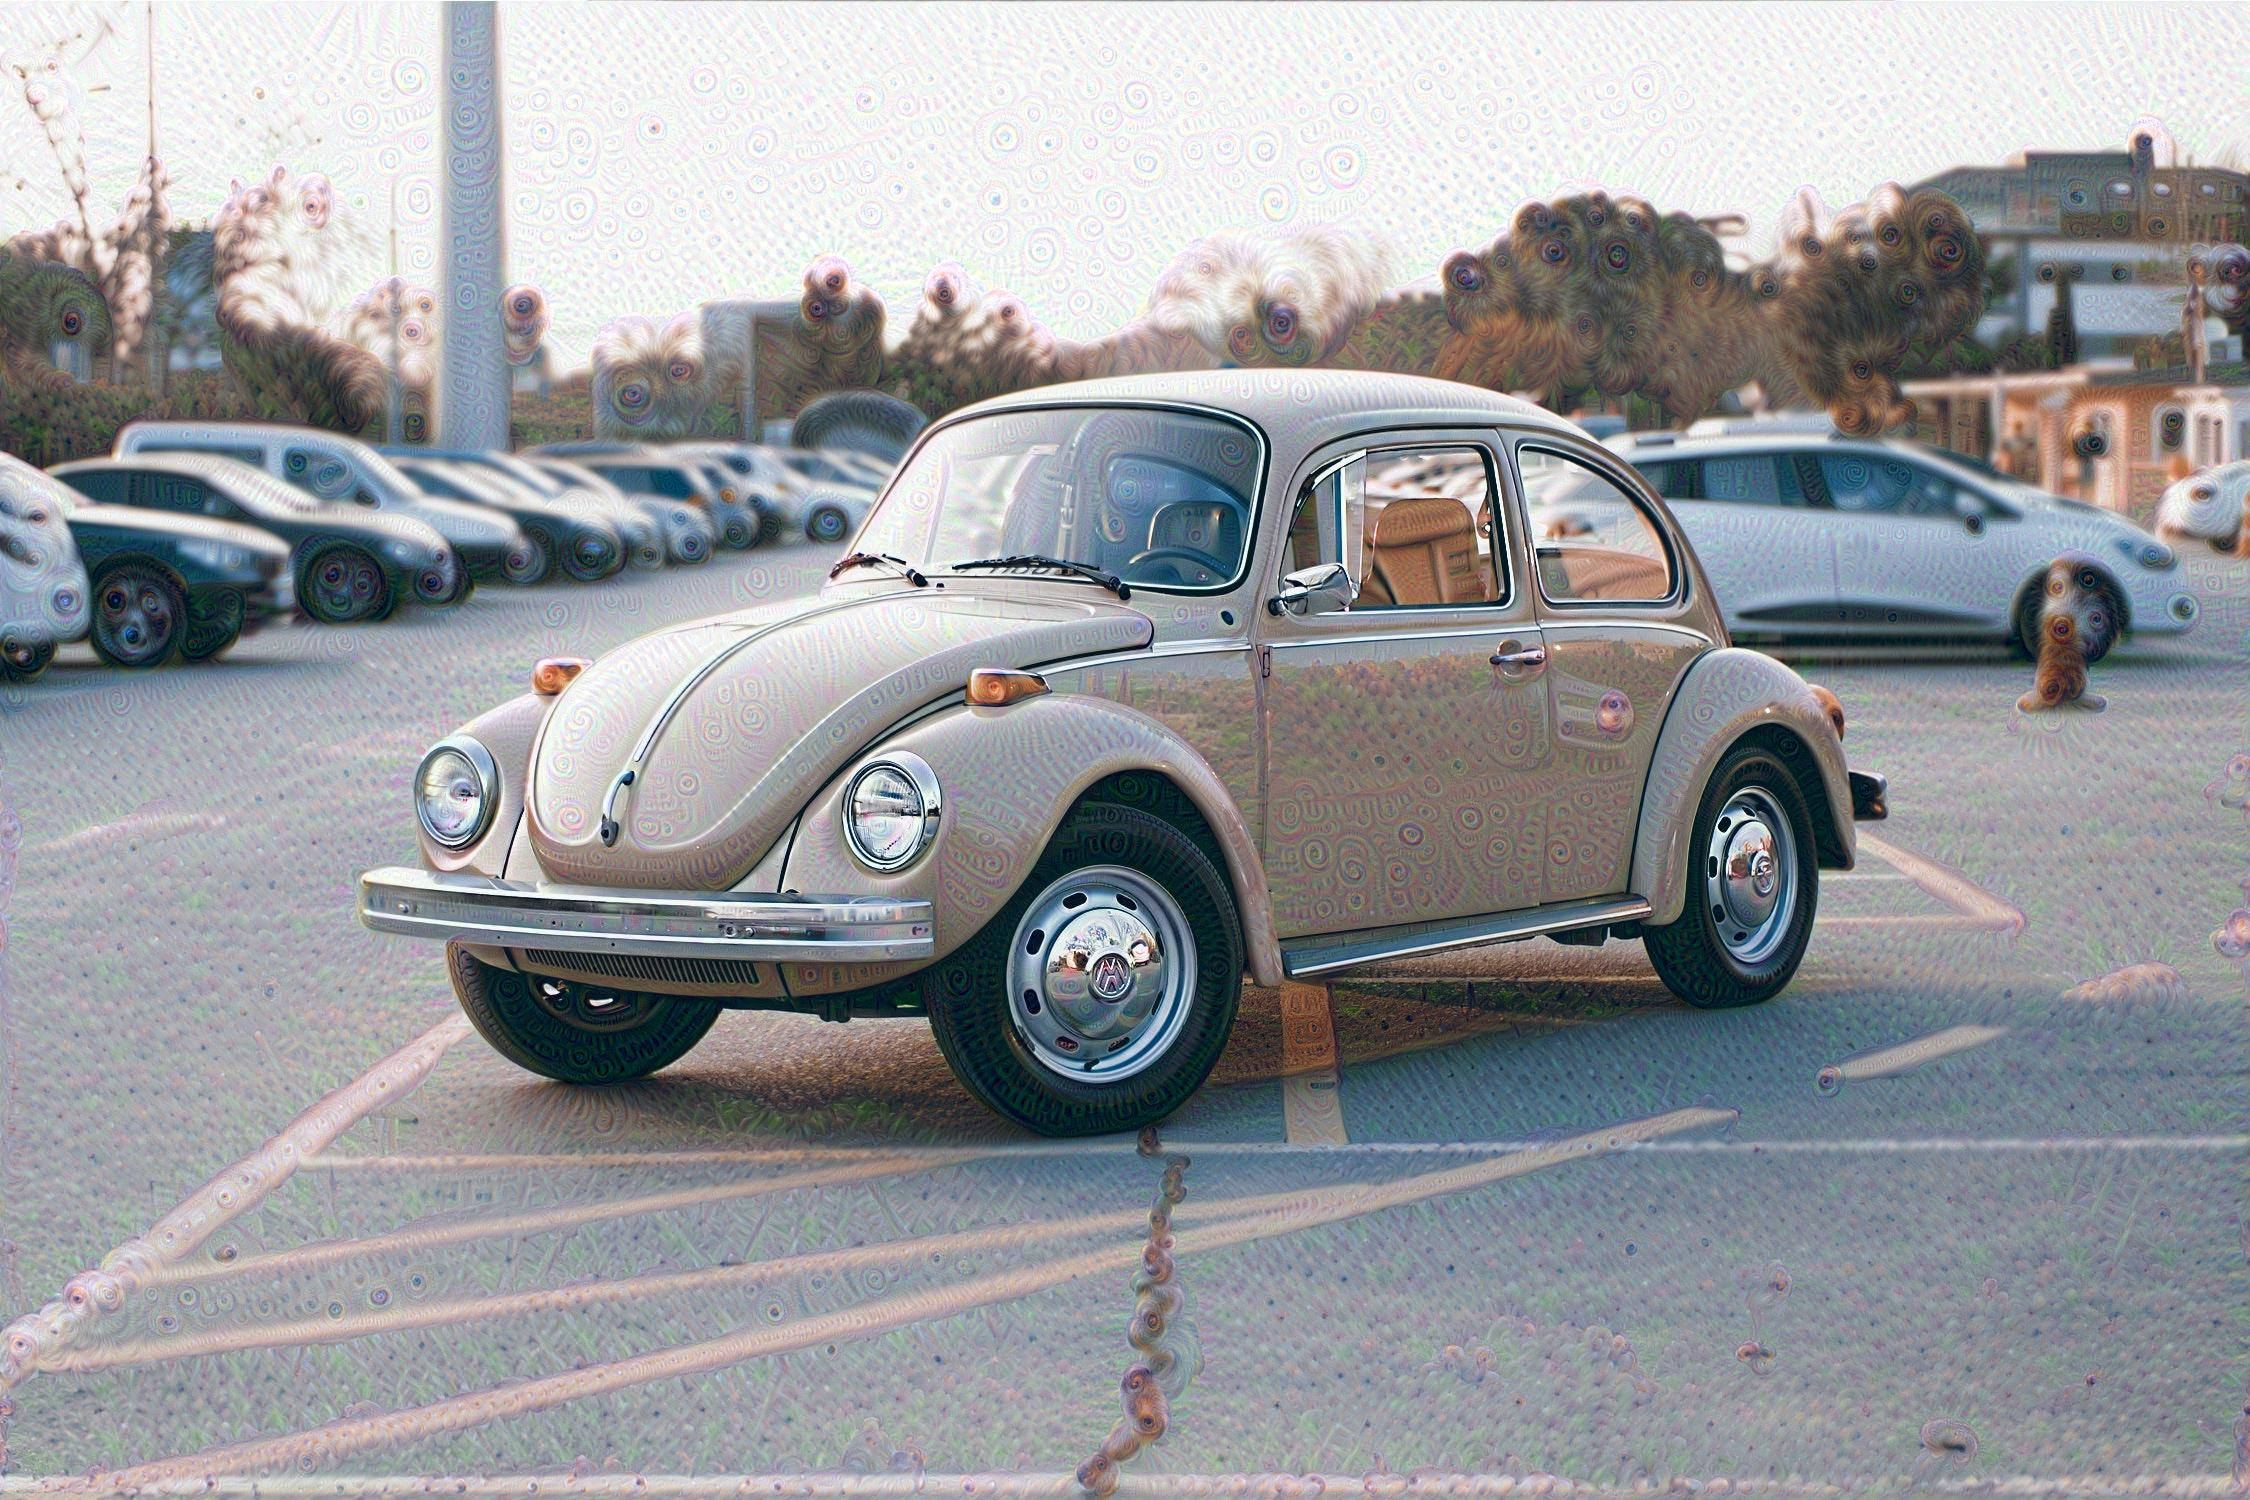

In [22]:
layer = "mixed4a_3x3_pre_relu"
final = render_deepdream(tf.square(T(layer)), img0)